<a href="https://colab.research.google.com/github/adel-nouar/ML_with_Rune/blob/main/09%20-%20Project%20-%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Install Torch
- Execute the following cell which will install **torch** and **torchvision**

In [1]:
!pip install torchvision

### Step 2: Import libraries

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

### Step 3: Download the CIFAR10 dataset
- Excute the cell below

In [3]:
data_path = 'downloads/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting downloads/cifar-10-python.tar.gz to downloads/
Files already downloaded and verified


### Step 4: Explore the dataset
- See the type of **cifar10**
- Get the length of **cifar10**
- Assign image and label of **cifar10** at index 1000
- Get the class name of label
    - HINT: Use **cifar10.classes[label]** to get the name

In [4]:
type(cifar10)

torchvision.datasets.cifar.CIFAR10

In [5]:
len(cifar10), len(cifar10_val)

(50000, 10000)

In [6]:
img, label = cifar10[1000]

In [7]:
cifar10.classes[label]

'truck'

### Step 5: Visualize the image
- Use **matplotlib** to visuazlize image
    - HINT: just use **plt.imshow(...)**

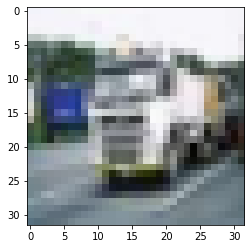

In [8]:
plt.imshow(img)

### Step 6: Transform images
- We need to convert the PIL image to a PyTorch tensor
- We can easily transform it by adding **transform=transforms.ToTensor()** when reading the dataset.
- This is given below (just execute)

In [10]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

### Step 7: Normalize images
- Now you have all images (transformed) in **tensor_cifar10**.
- To concatenate a stack of images use **torch.stack(..., dim=3)** on the images
    - HINT: Use list comprehension to get a list of images from **tensor_cifar10** (to exclude labels)
- Calculate the **mean(dim=1)** by applying it on the stack
- Calculate the **std(dim=1)** by applying it on the stack
- We will use the results in next step

In [11]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)

In [12]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [13]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

### Step 8: Normalize the data
- We can add a normalize transform with adding a **transforms.Compose([...])**, where the list will contain the transforms.
- The transform we want are **transforms.ToTensor()** and **transforms.Normalize(...)**
    - HINT: See lesson how it was done
- The **transforms.Normalize(...)** takes two tuples of the results from last step.
    - Note: that in the lesson it was single numbers, here we hare tuples.
- Read the datasets to **cifar10** with the new transform
- Read the validation dataset to **cifar10_val** with the new transform

In [16]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=False, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                               (0.2470, 0.2435, 0.2616))
                           ]))

In [17]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                               (0.2470, 0.2435, 0.2616))
                           ]))

### Step 9: Limit the dataset
- There are 10 classes in this dataset - to simplify, we will reduce it to two
- We will keep label 0 and 2 (**'airplane'** and **'bird'**)
- Use list comprehension to filter the datasets.
    - To simplify use a **label_map = {0: 0, 2: 1}**, which is used to map label 0 to 0 and label 2 to 1.
    - Then use list comprehension **[(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]**
    - And similar for **cifar10_val**

In [23]:
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

### Step 10: Create the model
- We create a simple model here
    - 3072 input nodes -> Linear with 512 nodes (Tanh acitivation)  -> Linear with 2 nodes (LogSoftmax activation)
- To do that use **nn.Sequential(...)** with the following arguments.
    - **nn.Linear(3072, 512)**
        - Bonus question: Why 3072 input nodes?
    - **nn.Tanh()**
    - **nn.Linear(512, 2)**
    - **nn.LogSoftmax(dim=1)**

In [20]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

### Step 11: Train the model
- Prepare training data

```Python
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

```

- Set the **learning_rate = 0.01** (to make it easy to adjust)
- Prepare optimizer and loss function.

```Python
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
```

- Run the training

```Python
n_epochs = 10
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        optimizer.zero_grad()

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
    
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
```

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 10
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        optimizer.zero_grad()

        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 0.062171
Epoch: 1, Loss: 0.163092
Epoch: 2, Loss: 0.109265
Epoch: 3, Loss: 0.141370
Epoch: 4, Loss: 0.173484
Epoch: 5, Loss: 0.050794
Epoch: 6, Loss: 0.041537
Epoch: 7, Loss: 0.053249
Epoch: 8, Loss: 0.105814
Epoch: 9, Loss: 0.018673


### Step 12: Test the model
- Run the following code (where we assume the test data is called **cifar10_val** and the model **model**.
```Python
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)
```

In [25]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                       shuffle=False)
correct = 0
total = 0
with torch.no_grad():
  for imgs, labels in val_loader:
      batch_size = imgs.shape[0]
      outputs = model(imgs.view(batch_size, -1))
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.989


### Step 13 (Optional): Improve the model
- Try to improve the model
    - Simple things you can play with
        - Adjust the learning rate
        - Run more epochs
        - Number of hidden nodes
    - Medium things to play with
        - Change activation functions
        - Add another layer
    - Advanced things
        - Let your imagination guide you
        - For inspiration see state of the art results ([wiki](https://en.wikipedia.org/wiki/CIFAR-10#Research_papers_claiming_state-of-the-art_results_on_CIFAR-10))

### Step 14 (Optional): Add more classes
- The dataset was limited to two classes (**airplane**s and **bird**s)
- Try to add another class (or more) and see how it changes